In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from plotting_helpers import functions as phf
plt.style.use('seaborn')


# Data

This dataset comes from a set of speed dating events.  It contains participants' demographics, interests, attributes they look for in dates, and other information participants provided about themselves.  For a complete data dictionary [click here](readme.ipynb).  

In [2]:
dating_dat = pd.read_csv('data/Speed Dating Data.csv')

# Insights

What interesting insights can we find in the data?  People often have intriguing subjective perceptions and patterns of behavior.  We take a look at a few interesting ones below.  What interesting things can you find?

In [3]:
user_grouped_data = dating_dat.groupby('iid')

u_matches = user_grouped_data.match.sum()
attr_diff = user_grouped_data['attr3_3'].max() - user_grouped_data['attr3_1'].max()
nan_idx = np.where(np.isnan(attr_diff))[0]
attr_diff.iloc[nan_idx] = user_grouped_data['attr3_2'].max() - user_grouped_data['attr3_1'].max()


mean_effects = []
std_error = []
matches_lower = [0, 1, 5, 9]
matches_upper = [0, 4, 8, 100]
for k in range(0, 4):
    attr_idx = np.where((u_matches >= matches_lower[k]) & (u_matches <= matches_upper[k]))[0]
    N = np.sum(~np.isnan(attr_diff.iloc[attr_idx]))
    mean_effects.append(np.nanmean(attr_diff.iloc[attr_idx]))
    std_error.append(np.nanstd(attr_diff.iloc[attr_idx])/np.sqrt(N))

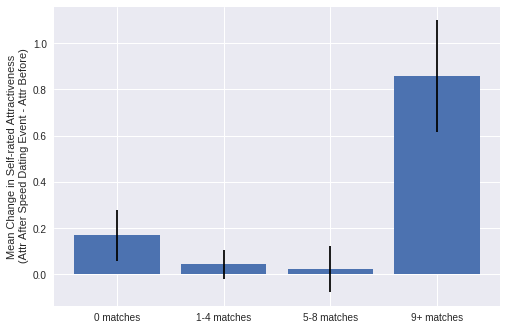

In [4]:
plt.bar([1,2,3,4], mean_effects, yerr = std_error)
plt.ylabel('Mean Change in Self-rated Attractiveness\n (Attr After Speed Dating Event - Attr Before)')
plt.xticks([1, 2, 3, 4], ['0 matches', '1-4 matches', '5-8 matches', '9+ matches'])
plt.show();

People's self-rating on their attractiveness before and after the speed dating experience stays relatively unchanged if they receive between 0 and 8 matches.

People with 9 or more matches experience a significant boost in how attractive the think they are after the speed dating experience.

In [5]:
partner_grouped_data = dating_dat.groupby('pid')


self_means = []
partner_means = []

attributes = ['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']
for ai, attribute in enumerate(attributes):
    self_means.append(np.nanmean(user_grouped_data[attribute].max()))
    partner_means.append(np.nanmean(partner_grouped_data[attributes[ai][:-3]].mean()))
    
self_means = np.array(self_means)
partner_means = np.array(partner_means)

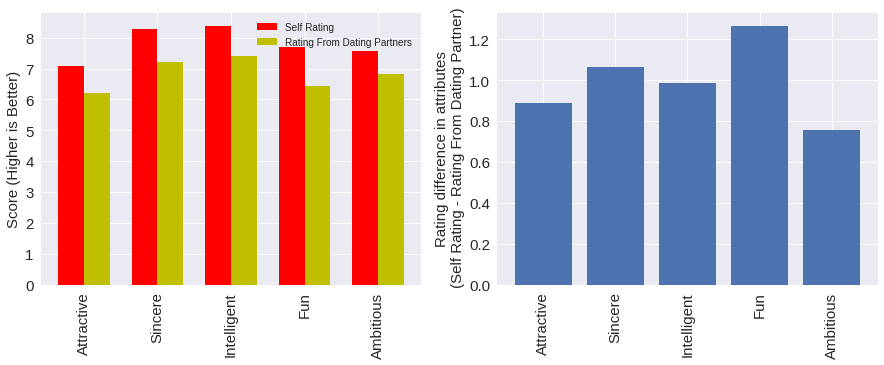

In [6]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ind = np.arange(5)
rects1 = ax1.bar(ind, self_means, 0.35, color='r')
rects2 = ax1.bar(ind + 0.35, partner_means, 0.35, color='y')
ax1.set_xticks(ind + 0.35 / 2)
ax1.set_xticklabels(('Attractive', 'Sincere', 'Intelligent', 'Fun', 'Ambitious'), rotation = 90)
ax1.set_ylabel('Score (Higher is Better)', fontsize=15)
ax1.legend(['Self Rating', 'Rating From Dating Partners'], loc=1)

ax2.bar(ind, self_means - partner_means)
ax2.set_xticks(ind)
ax2.set_xticklabels(('Attractive', 'Sincere', 'Intelligent', 'Fun', 'Ambitious'), rotation = 90)
ax2.set_ylabel('Rating difference in attributes\n (Self Rating - Rating From Dating Partner)', fontsize=15)

plt.show()

People rate themselves more generously than they rate their dating partners

The effect is comparable across all attributes.

In [7]:
ratings_by_age = [('Self Rating', [[],[]])]
        
for attribute in attributes:
    for gi in np.unique(dating_dat.gender):
        dat_idx = np.where((user_grouped_data.gender.max() == gi))[0]
        mean_attr = np.nanmean(user_grouped_data[attribute].max().iloc[dat_idx])
        ratings_by_age[0][1][gi].append(mean_attr)

ratings_dat = [['Attractive', 'Sincere', 'Intelligent', 'Fun', 'Ambitious']]
ratings_dat.extend(ratings_by_age)

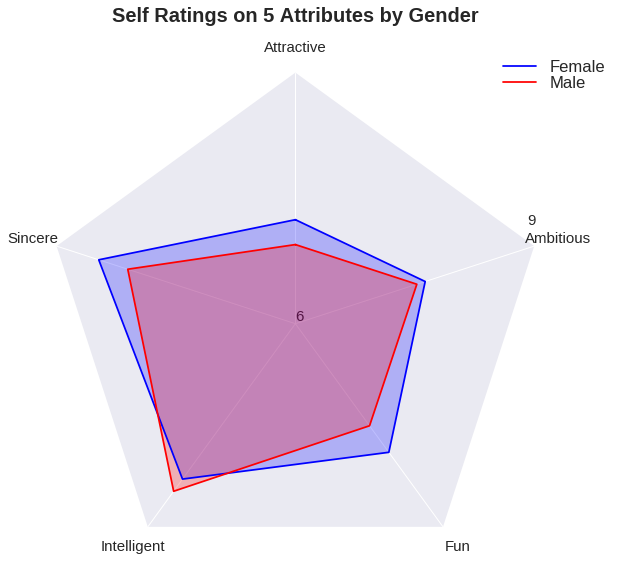

In [8]:
plt.rcParams['font.size'] = 20
phf.radar_plot(list(ratings_dat), colors = ['b','r'], frame = 'circle', 
           rmin = 6, rmax = 9, title = 'Self Ratings on 5 Attributes by Gender')

Female participants rate themselves higher on four of the 5 attributes compared tomale participants do, though these differences are generaly small.

# A Simple Model

Let's build a simple model to predict the probability of a match.  Note to avoid **target leakage**, or in other words, using data that includes direct information on whether a match occured or not (e.g. looking at the **decisions** for both participants).  Most fields in section 1 and 2 in the data dictionary should all be fair to use.

In [9]:
features = ['gender', 'order', 'int_corr', 'samerace', 'age', 'age_o', 'race_o', 'field_cd', 'exphappy']

In [10]:
dat_subset = dating_dat[features].copy()
dat_subset['match'] = dating_dat['match'].copy()
dat_subset = dat_subset.dropna()

#engineer a feature
dat_subset['age_diff'] = np.abs(dat_subset['age'] - dat_subset['age_o'])

In [11]:
#add age_diff in our feature list
features = ['gender', 'order', 'int_corr', 'samerace', 'age', 'age_o', 'age_diff', 'race_o', 'field_cd', 'exphappy']

In [12]:
X = dat_subset[features]
Y = dat_subset['match']

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [14]:
rfmodel = RandomForestClassifier(class_weight='balanced', max_depth = 5, n_estimators=500, oob_score = True)

In [15]:
rfmodel.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [16]:
print(rfmodel.oob_score_)
print(rfmodel.score(X_test, Y_test))

0.618138424821
0.616474096161


In [17]:
Y_pred = rfmodel.predict(X_test)

Feature ranking:
1. feature 2 (0.192845)
2. feature 6 (0.181042)
3. feature 1 (0.142609)
4. feature 4 (0.118649)
5. feature 5 (0.109785)
6. feature 8 (0.104216)
7. feature 9 (0.075647)
8. feature 7 (0.040366)
9. feature 3 (0.024158)
10. feature 0 (0.010682)


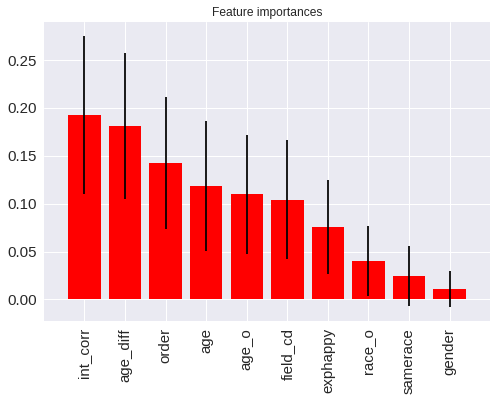

In [18]:
phf.plot_importances(rfmodel, features)

Confusion matrix, without normalization
[[1442  778]
 [ 251  212]]
Normalized confusion matrix
[[ 0.65  0.35]
 [ 0.54  0.46]]


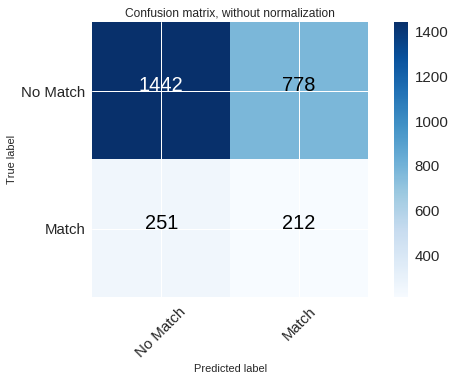

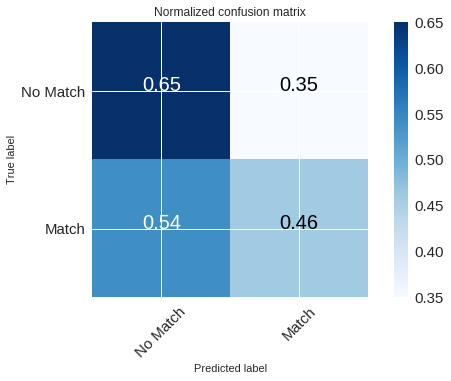

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
phf.plot_confusion_matrix(cnf_matrix, classes=['No Match', 'Match'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
phf.plot_confusion_matrix(cnf_matrix, classes=['No Match', 'Match'], normalize=True,
                      title='Normalized confusion matrix')

plt.show();

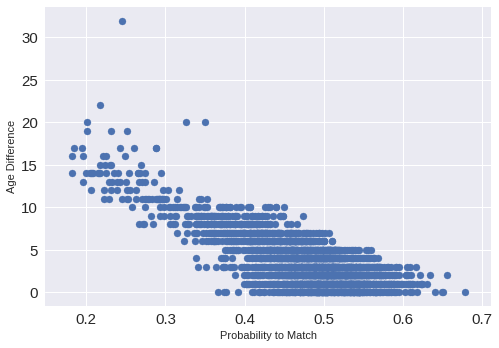

In [20]:
plt.scatter(rfmodel.predict_proba(X_test)[:,1], X_test['age_diff'])
plt.xlabel('Probability to Match')
plt.ylabel('Age Difference')